In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [5]:

# set the seaborn run command for font parameters
sns.set(rc={'font.weight': 'bold'}, font_scale=1.3)

# Load the data
data = pd.read_csv('../data/crime_data_cleaned.csv')

# remove spaces from column names
data.columns = data.columns.str.replace(' ', '')

# format day month year
data['DATEOCC'] = pd.to_datetime(data['DATEOCC'], format='%Y-%m-%d')

print('This dataset shows {} observations and {} features'.format(data.shape[0], data.shape[1]))

This dataset shows 549861 observations and 36 features


### Building a Data Model
We want to build a model that will serve to influence a metric. The metric we are interested in is the clearance rate of crimes. The clearance rate is the percentage of crimes that are "solved" or "cleared" by the police. A crime is considered cleared when an arrest is made, when a suspect is charged, or when the case is closed in some other way. The clearance rate is calculated by dividing the number of crimes that are cleared by the total number of crimes recorded.


### Analyze Crimes Committed - Year over Year

In [6]:
serious_crimes = (data.query('YEAR != 2024') # remove 2024, incomplete year
                  .groupby(['crime_category','YEAR'])['DateRptd'] # group by crime category and year
                    .count().to_frame().reset_index()) # count the number of reports and reset index

serious_crimes[:5] # observe the first 5 rows

,crime_category,YEAR,DateRptd
0,AGGRAVATED ASSAULT,2020,18485
1,AGGRAVATED ASSAULT,2021,19917
2,AGGRAVATED ASSAULT,2022,20059
3,AGGRAVATED ASSAULT,2023,19908
4,ARSON,2020,665


### Plot the Data

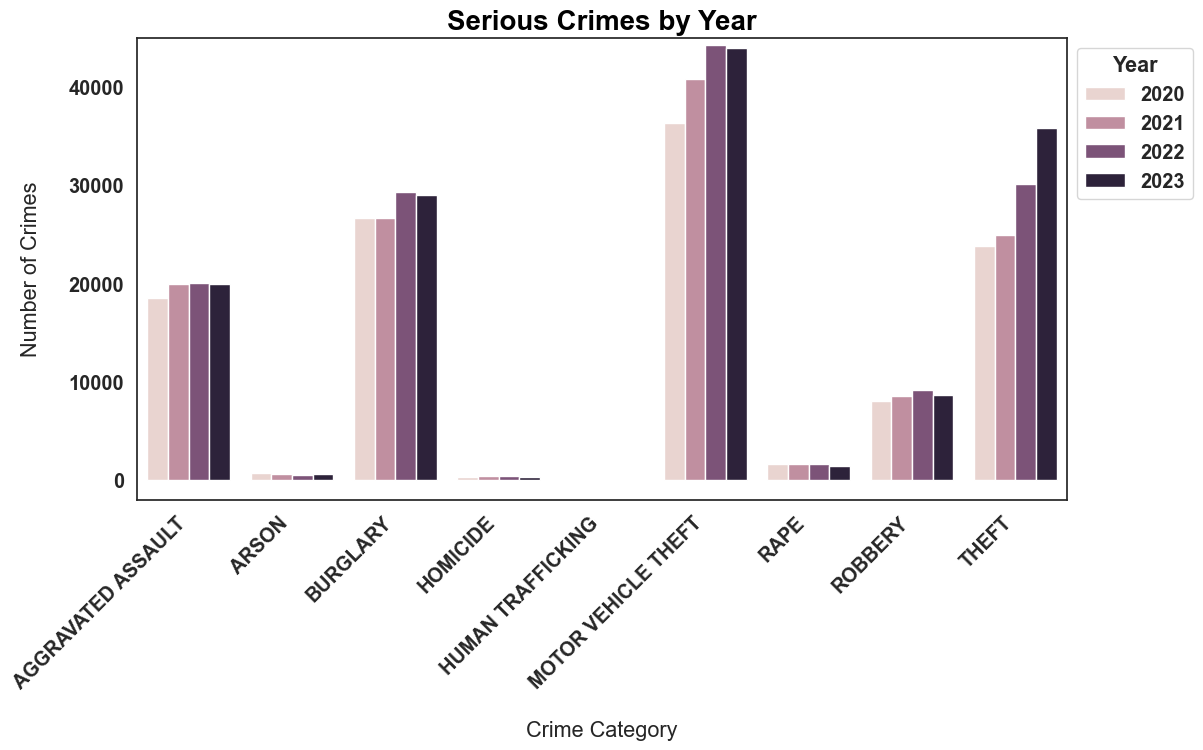

In [9]:
# set white background
sns.set_style('white')

# create a bar plot of the crime_category as x and YEAR as Y and YEAR as hue
plt.figure(figsize=(12,6))
sns.barplot(x='crime_category', y='DateRptd', hue='YEAR', data=serious_crimes)
plt.title('Serious Crimes by Year', fontsize=20, fontweight='bold', color='black')

# increase space between y label and axis
plt.ylabel('Number of Crimes', labelpad=20)

plt.ylim(-2000, 45000)

# increase space between x label and axis
plt.xlabel('Crime Category', labelpad=20)

plt.xticks(rotation=45, ha='right')

# plot the legend outside the plot
plt.legend(title='Year', bbox_to_anchor=(1, 1))

plt.show()

### Analyze the Year over Year Clearance Rate of Crimes

In [11]:
# remove 2024, incomplete year
data = data.loc[data['YEAR'] != 2024]

# first create the cleared dataframe, that includes Year, crime_category and sum of cleared crimes
cleared = data.groupby(['YEAR','crime_category'])['cleared'].sum().reset_index()

# create crimes column, which is just the total crimes reported for that category, year
cleared['crimes'] = data.groupby(['YEAR','crime_category'])['DateRptd'].count().values

# create cleared rate column
cleared['rate'] = (cleared['cleared'] / cleared['crimes']).round(2)

# display the first 10 rows
cleared[:10]


,YEAR,crime_category,cleared,crimes,rate
0,2020,AGGRAVATED ASSAULT,8730,18485,0.47
1,2020,ARSON,37,665,0.06
2,2020,BURGLARY,2328,26650,0.09
3,2020,HOMICIDE,217,352,0.62
4,2020,HUMAN TRAFFICKING,7,15,0.47
5,2020,MOTOR VEHICLE THEFT,2522,36349,0.07
6,2020,RAPE,737,1586,0.46
7,2020,ROBBERY,2532,8018,0.32
8,2020,THEFT,2228,23765,0.09
9,2021,AGGRAVATED ASSAULT,9291,19917,0.47


### Plot the Data

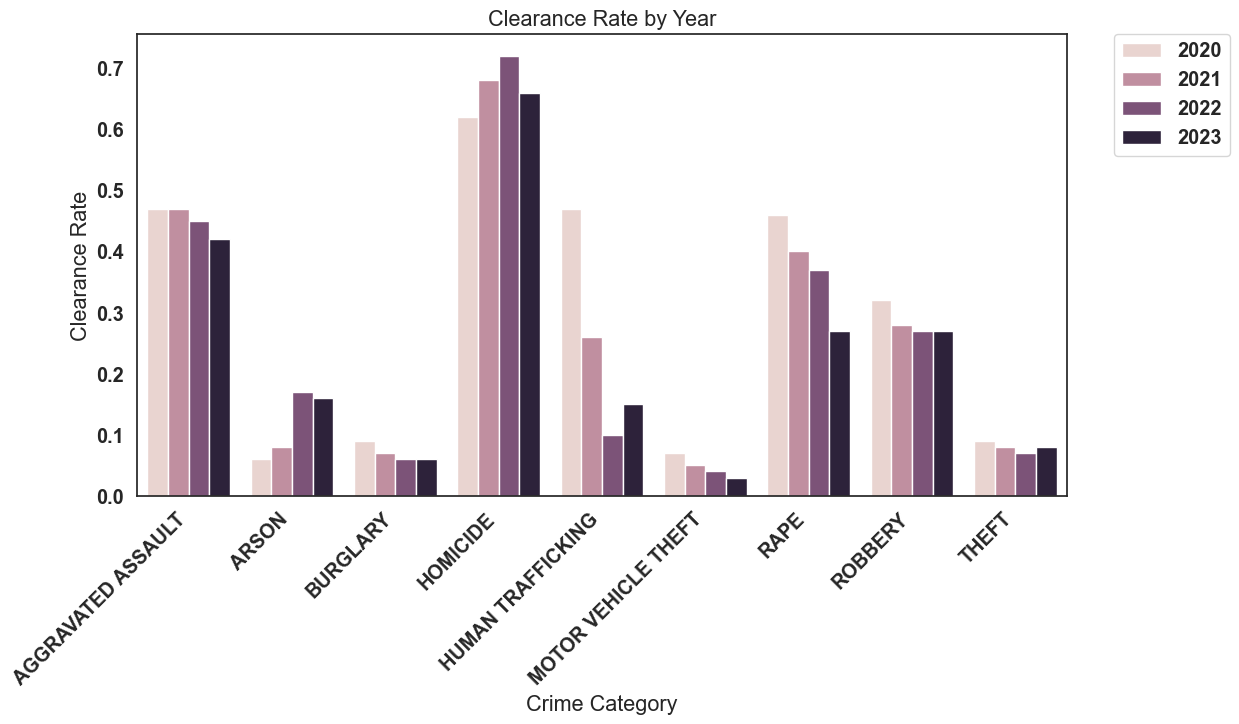

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.barplot(x='crime_category', y='rate', hue='YEAR', data=cleared)
plt.title('Clearance Rate by Year')
plt.ylabel('Clearance Rate')
plt.xlabel('Crime Category')
plt.xticks(rotation=45, ha='right')

# place the legend outside of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

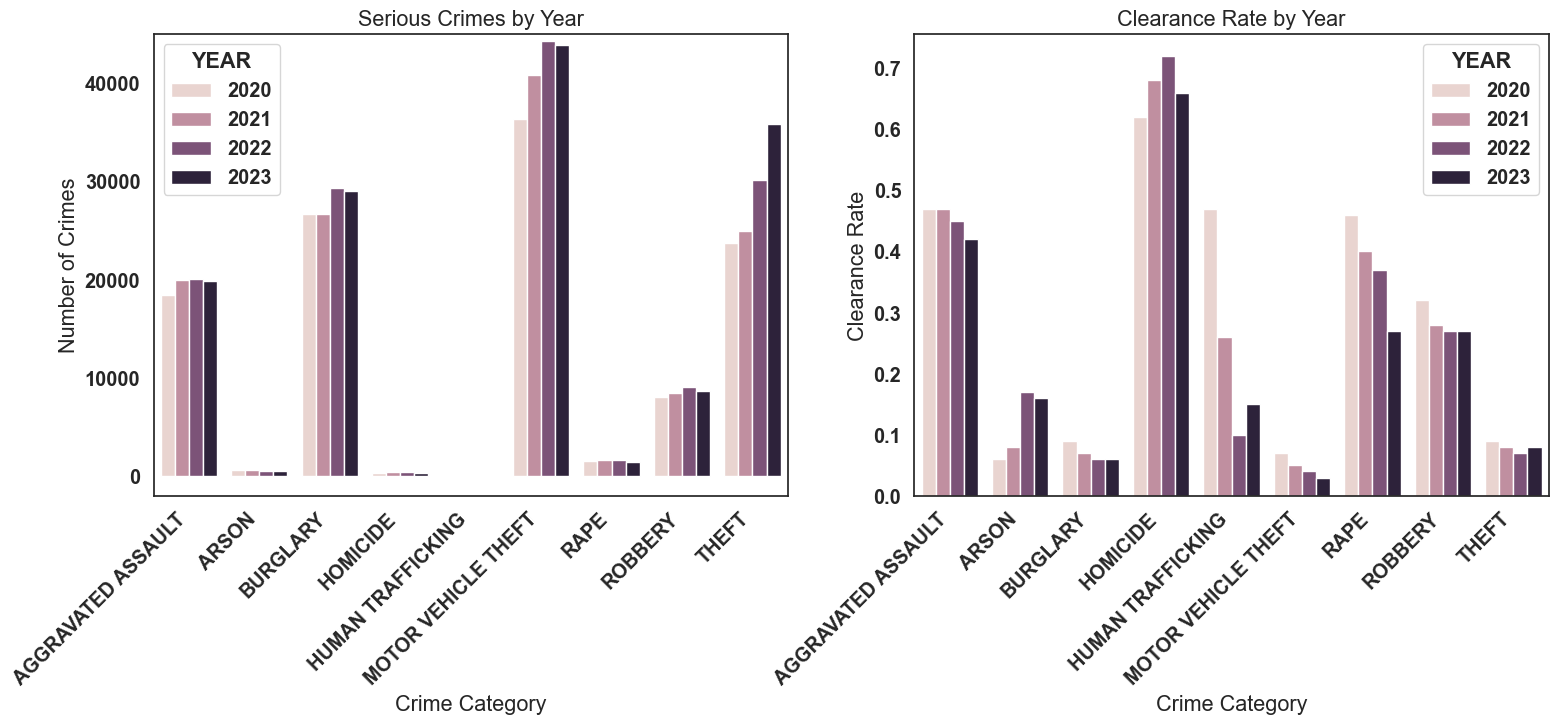

In [16]:
# create subplots next to each other, crimes and clearance rate
fig, ax = plt.subplots(1, 2, figsize=(18,6))

# create a bar plot of the crime_category as x and YEAR as Y and YEAR as hue
sns.barplot(x='crime_category', y='DateRptd', hue='YEAR', data=serious_crimes, ax=ax[0])
ax[0].set_title('Serious Crimes by Year')
ax[0].set_ylabel('Number of Crimes')
ax[0].set_xlabel('Crime Category')
ax[0].set_ylim(-2000, 45000)
for item in ax[0].get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

# create a bar plot of the crime_category as x and YEAR as Y and YEAR as hue
sns.barplot(x='crime_category', y='rate', hue='YEAR', data=cleared, ax=ax[1])
ax[1].set_title('Clearance Rate by Year')
ax[1].set_ylabel('Clearance Rate')
ax[1].set_xlabel('Crime Category')
plt.xticks(rotation=45, ha='right')
plt.show()

### There is a huge class imblance.  There are 55,000 observations of arrest, compared to 505,331 observations of no arrest.  This is a class imbalance of 1:10.  We will need to address this in our model.

### We can go deeper into crimes and look at them individually, by severity.

### First we can look into Homicide

In [18]:
# isolate arrests made for Homicide
data.query('crime_category == "HOMICIDE"')['cleared'].value_counts()

cleared
1    987
0    483
Name: count, dtype: int64

In [19]:
# create a dataframe for criminal homicide 
homicide = data.query('crime_category == "HOMICIDE"')

In [20]:
homicide.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON', 'crime_category',
       'YEAR', 'MONTH', 'DAY', 'HOUR', 'TIME_OF_DAY', 'REPORTING_DELAY',
       'cleared'],
      dtype='object')

In [22]:
# build the model islolating appropriate columns
homicide = homicide.loc[:,['DateRptd', 'DATEOCC', 'TIMEOCC','AREANAME','CrmCdDesc','VictAge','VictSex', 'VictDescent','PremisDesc','WeaponDesc', 'Status','StatusDesc','crime_category','YEAR', 'MONTH', 'DAY', 'HOUR', 'TIME_OF_DAY', 'REPORTING_DELAY','cleared']]

homicide[:1]

,DateRptd,DATEOCC,TIMEOCC,AREANAME,CrmCdDesc,VictAge,VictSex,VictDescent,PremisDesc,WeaponDesc,Status,StatusDesc,crime_category,YEAR,MONTH,DAY,HOUR,TIME_OF_DAY,REPORTING_DELAY,cleared
2317,2020-05-16,2020-05-15,1945,Central,CRIMINAL HOMICIDE,57,M,H,STAIRWELL*,UNKNOWN TYPE CUTTING INSTRUMENT,AA,Adult Arrest,HOMICIDE,2020,5,15,19,Evening,1,1


In [ ]:
# fill the nulls in WeaponDesc with ''
homicide['WeaponDesc'] = homicide['WeaponDesc'].fillna('')

### We will use NLP to vectorize the words and run a logistic regression model to look at words that lead to arrest
We will look at the following columns:
`PremisDesc` and `WeaponDesc` to see if we can extract any words that can predict the arrest of a crime.
<br>
Here are the steps involved:
1.  Create training and testing data
2.  Vectorize the words
3.  Run a logistic regression model
4.  Look at the words that lead to arrest


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X = homicide[['WeaponDesc']]
y = homicide['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

In [ ]:
# display max rows
pd.set_option('display.max_rows', None)

list(X_train.values)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# create the vectorizer
vectorizer = TfidfVectorizer(
                             stop_words='english',
                             max_features=200,
                             min_df=0.001
                             )

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train['WeaponDesc'])

# transform the test data
X_test_tfidf = vectorizer.transform(X_test['WeaponDesc'])

X_train_tfidf.shape, X_test_tfidf.shape


### Scale The Data

In [ ]:
# scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_tfidf_scaled.shape, X_test_tfidf_scaled.shape

### Fit the model

In [ ]:
# build the model
from sklearn.linear_model import LogisticRegression

# instantiate the model
model = LogisticRegression()

# fit the model
model.fit(X_train_tfidf_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_tfidf_scaled)


### Evaluate the fitted model

In [ ]:

# evaluate the model
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


In [ ]:

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.show()


In [ ]:
# create df with coefs and features
coefs = model.coef_.flatten()
features = vectorizer.get_feature_names_out()

coefs_df = pd.DataFrame({'feature': features, 'coef': coefs})

coefs_df = coefs_df.sort_values(by='coef', ascending=True)

bottom_20_words = coefs_df[:20]

top_20_words = coefs_df[-20:]

In [ ]:
bottom_20_words.sort_values(by='coef', ascending=True, inplace=True)

bottom_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Bottom 20 Words associated with an arrest', fontsize=16)
plt.xticks(rotation=45);

In [ ]:
# plot top 20 words
top_20_words.sort_values(by='coef', ascending=False, inplace=True)

top_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Top 20 Words Associated with Homicide Arrests', fontsize=16)
plt.xticks(rotation=45);


### Let's apply the same rigor to PremisDesc

In [ ]:
# resolve the nulls
homicide['PremisDesc'] = homicide['PremisDesc'].fillna('')

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X = homicide[['PremisDesc']]
y = homicide['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape

### Vectorize the words

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


# create the vectorizer
vectorizer = TfidfVectorizer(
                             stop_words='english',
                             max_features=200,
                             min_df=0.001
                             )

# fit the vectorizer
X_train_tfidf = vectorizer.fit_transform(X_train['PremisDesc'])

# transform the test data
X_test_tfidf = vectorizer.transform(X_test['PremisDesc'])

X_train_tfidf.shape, X_test_tfidf.shape


### Scale the data

In [ ]:
scaler = StandardScaler(with_mean=False)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_tfidf_scaled.shape, X_test_tfidf_scaled.shape

### Fit the model

In [ ]:
# instantiate the model
model = LogisticRegression()

# fit the model
model.fit(X_train_tfidf_scaled, y_train)

# make predictions
y_pred = model.predict(X_test_tfidf_scaled)


### Evaluate the fitted model

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

disp.plot(cmap='Blues')

plt.show()


### Evaluate the coefficients

In [ ]:
# create df with coefs and features
coefs = model.coef_.flatten()
features = vectorizer.get_feature_names_out()

coefs_df = pd.DataFrame({'feature': features, 'coef': coefs})

coefs_df = coefs_df.sort_values(by='coef', ascending=True)

bottom_20_words = coefs_df[:20]

top_20_words = coefs_df[-20:]

In [ ]:
bottom_20_words.sort_values(by='coef', ascending=True, inplace=True)

bottom_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Bottom 20 Words associated with an arrest', fontsize=16)
# align x-axis labels for readability
plt.xticks(rotation=45, ha='right');

In [ ]:
# plot top 20 words
top_20_words.sort_values(by='coef', ascending=False, inplace=True)

top_20_words.plot(kind='bar', x='feature', y='coef', figsize=(15, 5), color='blue', legend=False)
plt.suptitle('Top 20 Words Associated with Homicide Arrests', fontsize=16)
# align the labels 
plt.xticks(rotation=45, ha='right');
    


### Finalize the data model

In [23]:
display(homicide.columns)
display(homicide[:3])

Index(['DateRptd', 'DATEOCC', 'TIMEOCC', 'AREANAME', 'CrmCdDesc', 'VictAge',
       'VictSex', 'VictDescent', 'PremisDesc', 'WeaponDesc', 'Status',
       'StatusDesc', 'crime_category', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'TIME_OF_DAY', 'REPORTING_DELAY', 'cleared'],
      dtype='object')

,DateRptd,DATEOCC,TIMEOCC,AREANAME,CrmCdDesc,VictAge,VictSex,VictDescent,PremisDesc,WeaponDesc,Status,StatusDesc,crime_category,YEAR,MONTH,DAY,HOUR,TIME_OF_DAY,REPORTING_DELAY,cleared
2317,2020-05-16,2020-05-15,1945,Central,CRIMINAL HOMICIDE,57,M,H,STAIRWELL*,UNKNOWN TYPE CUTTING INSTRUMENT,AA,Adult Arrest,HOMICIDE,2020,5,15,19,Evening,1,1
3181,2020-07-24,2020-07-23,2145,Newton,CRIMINAL HOMICIDE,31,M,A,SIDEWALK,UNKNOWN FIREARM,IC,Invest Cont,HOMICIDE,2020,7,23,21,Evening,1,0
3961,2020-06-17,2020-06-17,50,77th Street,CRIMINAL HOMICIDE,19,M,B,STREET,UNKNOWN FIREARM,AA,Adult Arrest,HOMICIDE,2020,6,17,50,NaN,0,1


In [24]:
drop_cols = ['DateRptd','DATEOCC','TIMEOCC','CrmCdDesc','Status','StatusDesc','crime_category']

homicide.drop(drop_cols, axis=1, inplace=True)

homicide.columns

Index(['AREANAME', 'VictAge', 'VictSex', 'VictDescent', 'PremisDesc',
       'WeaponDesc', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'TIME_OF_DAY',
       'REPORTING_DELAY', 'cleared'],
      dtype='object')

In [25]:
homicide[:5]

,AREANAME,VictAge,VictSex,VictDescent,PremisDesc,WeaponDesc,YEAR,MONTH,DAY,HOUR,TIME_OF_DAY,REPORTING_DELAY,cleared
2317,Central,57,M,H,STAIRWELL*,UNKNOWN TYPE CUTTING INSTRUMENT,2020,5,15,19,Evening,1,1
3181,Newton,31,M,A,SIDEWALK,UNKNOWN FIREARM,2020,7,23,21,Evening,1,0
3961,77th Street,19,M,B,STREET,UNKNOWN FIREARM,2020,6,17,50,NaN,0,1
3989,Northeast,37,M,W,STREET,BLUNT INSTRUMENT,2020,9,12,12,Morning,0,1
4284,Newton,30,F,B,SIDEWALK,UNKNOWN FIREARM,2020,11,15,15,Afternoon,0,1


### Model is ready for machine learning


In [26]:
# imputation strategy

# for missing VictSex, fill with 'U' for unknown
homicide['VictSex'] = homicide['VictSex'].fillna('')

# for missing VictDescent, fill with 'U' for unknown
homicide['VictDescent'] = homicide['VictDescent'].fillna('')

# for missing Time_of_day, fill with missing
homicide['TIME_OF_DAY'] = homicide['TIME_OF_DAY'].fillna('')


In [27]:
homicide.to_csv('../data/homicide.csv', index=False)
print('Homicide data model successfully saved.')

Homicide data model successfully saved.
